<a href="https://colab.research.google.com/github/gabrieladamasceno/Model_Attacks/blob/main/Random_Forest_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Mounted at /content/gdrive


In [ ]:
pip install imbalanced-learn


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is inc

In [ ]:
!pip install gputil


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=b0dd82c4c2944d6fa5ed4e656b6584b2b5bef670f920e7ef0483b514e975b48e
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil


In [ ]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [ ]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [ ]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Monitor Resource =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Training =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Start of Training]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Start] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        print(f"[Epoch {epoch + 1} - End] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Prediction/Test =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Start of Prediction/Test]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i])

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Energy
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Graphs
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memory
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
def monitor_train_generic(model, X_train, y_train, model_name="model"):
    print(f"\n[Start of Training - {model_name}]")
    process = psutil.Process(os.getpid())

    # Start
    cpu_start = process.cpu_percent(interval=None)
    mem_start = process.memory_info().rss / (1024 * 1024)
    start_time = time.time()

    model.fit(X_train, y_train)

    # End
    cpu_end = process.cpu_percent(interval=None)
    mem_end = process.memory_info().rss / (1024 * 1024)
    end_time = time.time()

    total_time = end_time - start_time
    avg_cpu = (cpu_start + cpu_end) / 2
    avg_mem = (mem_start + mem_end) / 2
    freq_ghz = 2.0

    # Energy
    energia = calcular_energia(avg_cpu, freq_ghz, total_time)

    print(f"[End of Training - {model_name}]")
    print(f"Time: {total_time:.2f}s")
    print(f"CPU: {avg_cpu:.2f}%")
    print(f"Memory: {avg_mem:.2f} MB")
    print(f"Energy: {energia:.2e} Joules")

    return {
        'total_time': total_time,
        'avg_cpu': avg_cpu,
        'avg_mem': avg_mem,
        'energia': energia
    }


====== Zero-Day: ICMPFlood ======
Total ICMPFlood in the original dataset: 1155
  Zero-days removed from training: 917
  Zero-day in the original test: 238
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 131.08s
CPU: 50.00%
Memory: 3112.95 MB
Energy: 1.31e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.47 seconds
Average CPU usage (Test): 0.66%
Average memory usage (Test): 3130.95 MB
Estimated energy consumption: 5.78 Joules


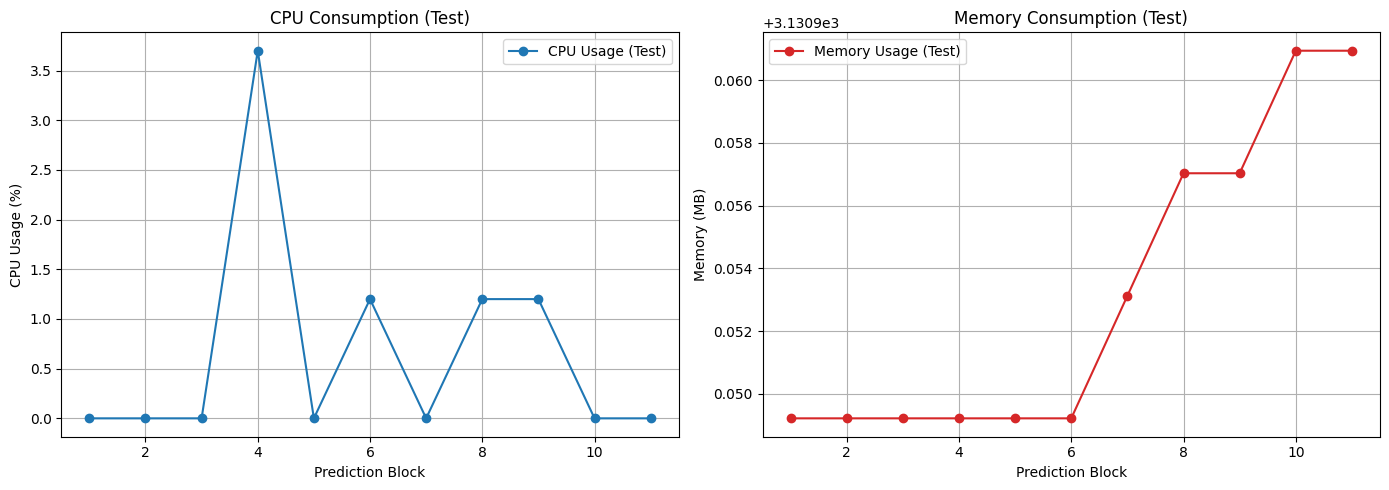


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.19 seconds
Average CPU usage (Test): 1.00%
Average memory usage (Test): 3133.77 MB
Estimated energy consumption: 9.49 Joules


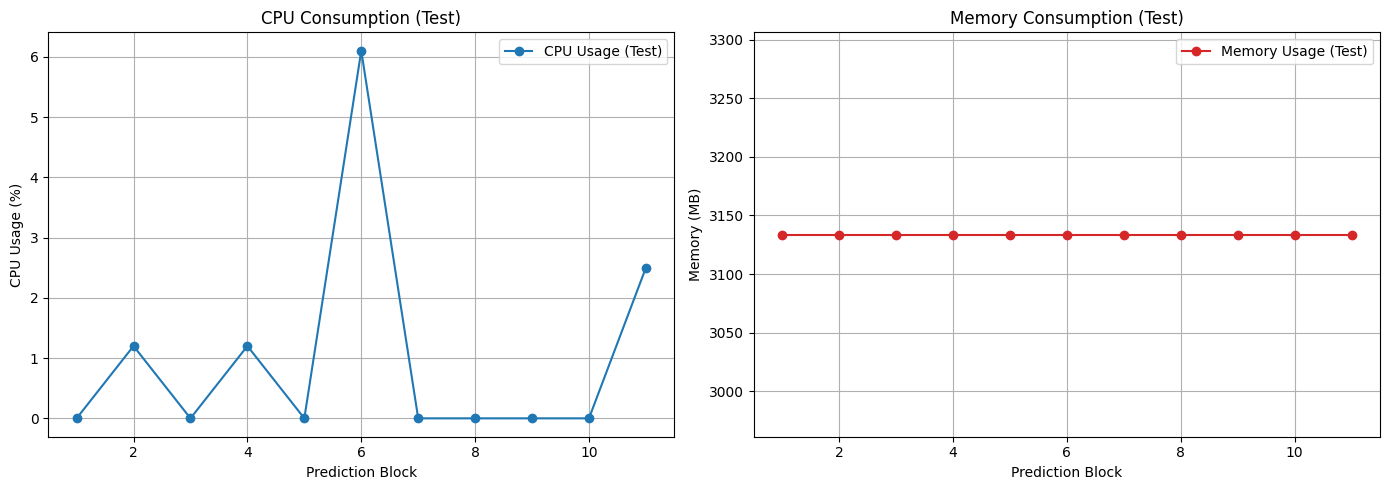

ROC FULL=1.0000
PR FULL=1.0000

====== Zero-Day: UDPFlood ======
Total UDPFlood in the original dataset: 457340
  Zero-days removed from training: 365919
  Zero-day in the original test: 91421
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 91.30s
CPU: 50.00%
Memory: 3005.43 MB
Energy: 9.13e+07 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.24 seconds
Average CPU usage (Test): 2.58%
Average memory usage (Test): 3020.01 MB
Estimated energy consumption: 307.77 Joules


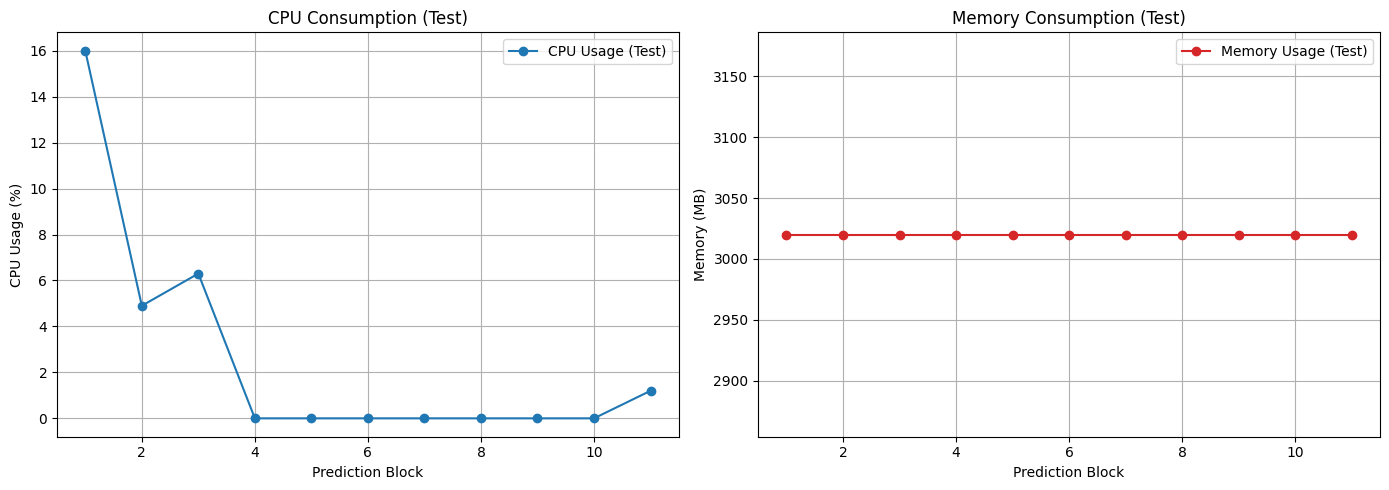


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.51 seconds
Average CPU usage (Test): 1.12%
Average memory usage (Test): 3020.02 MB
Estimated energy consumption: 16.93 Joules


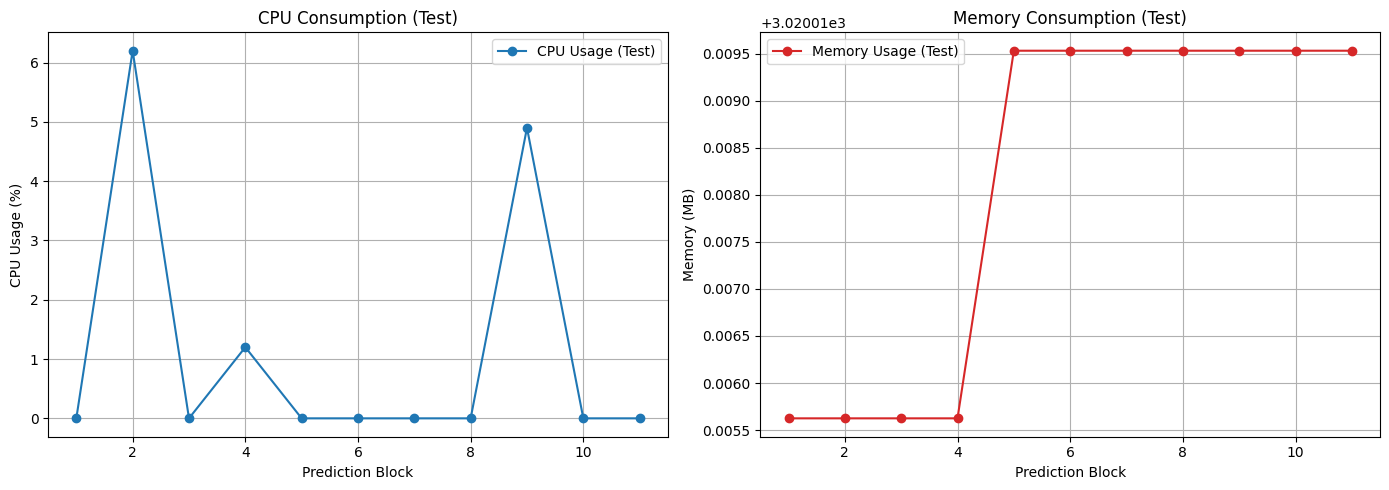

ROC FULL=0.9541
PR FULL=0.9758

====== Zero-Day: SYNFlood ======
Total SYNFlood in the original dataset: 9721
  Zero-days removed from training: 7802
  Zero-day in the original test: 1919
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 127.26s
CPU: 49.95%
Memory: 3431.85 MB
Energy: 1.27e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.45 seconds
Average CPU usage (Test): 8.15%
Average memory usage (Test): 3431.87 MB
Estimated energy consumption: 10576.03 Joules


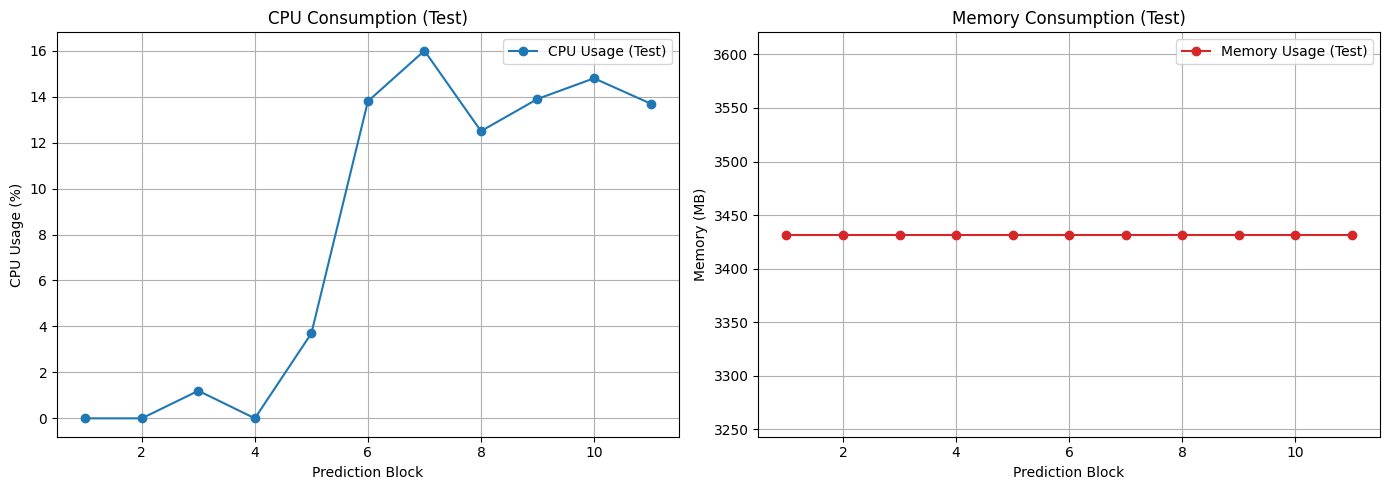


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.21 seconds
Average CPU usage (Test): 5.56%
Average memory usage (Test): 3431.88 MB
Estimated energy consumption: 1663.22 Joules


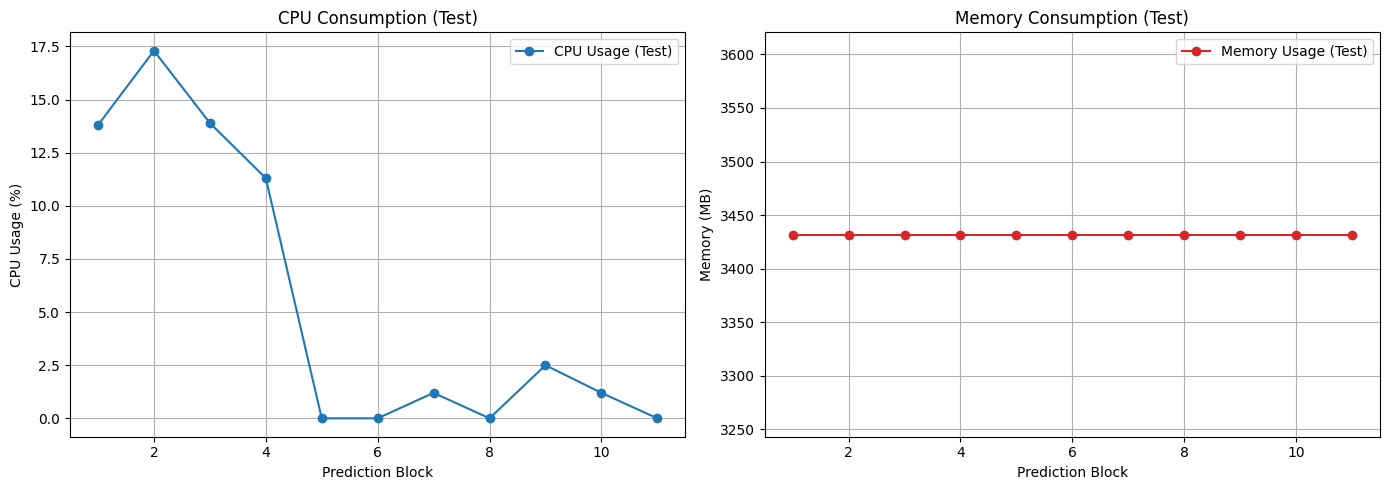

ROC FULL=1.0000
PR FULL=1.0000

====== Zero-Day: SYNScan ======
Total SYNScan in the original dataset: 20043
  Zero-days removed from training: 16149
  Zero-day in the original test: 3894
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 124.03s
CPU: 50.00%
Memory: 3357.23 MB
Energy: 1.24e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.44 seconds
Average CPU usage (Test): 11.24%
Average memory usage (Test): 3357.25 MB
Estimated energy consumption: 27651.75 Joules


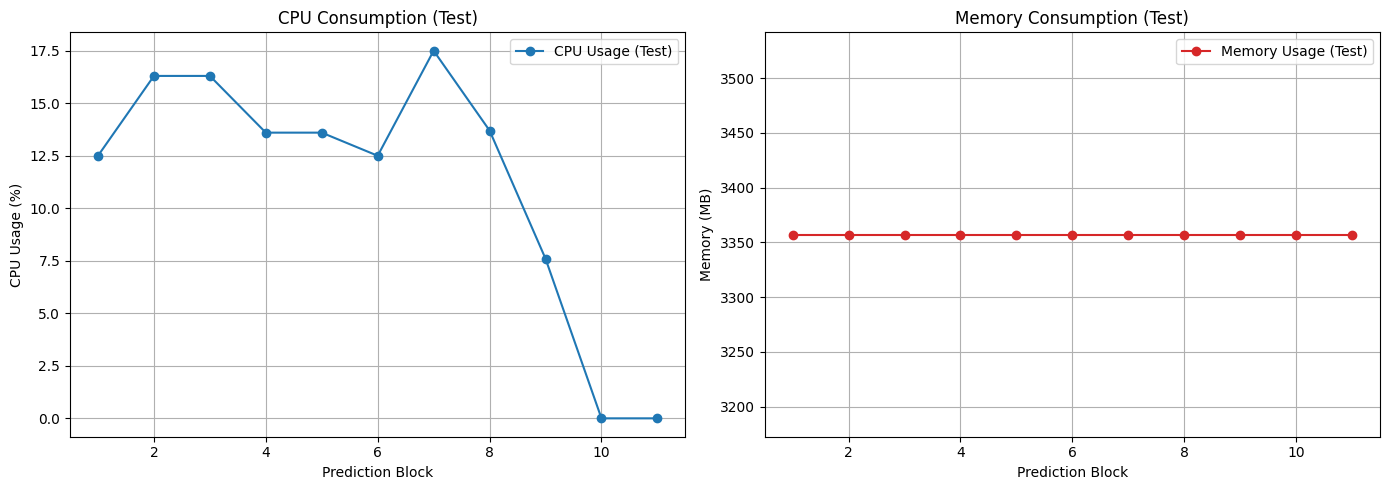


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.21 seconds
Average CPU usage (Test): 0.89%
Average memory usage (Test): 3357.26 MB
Estimated energy consumption: 6.85 Joules


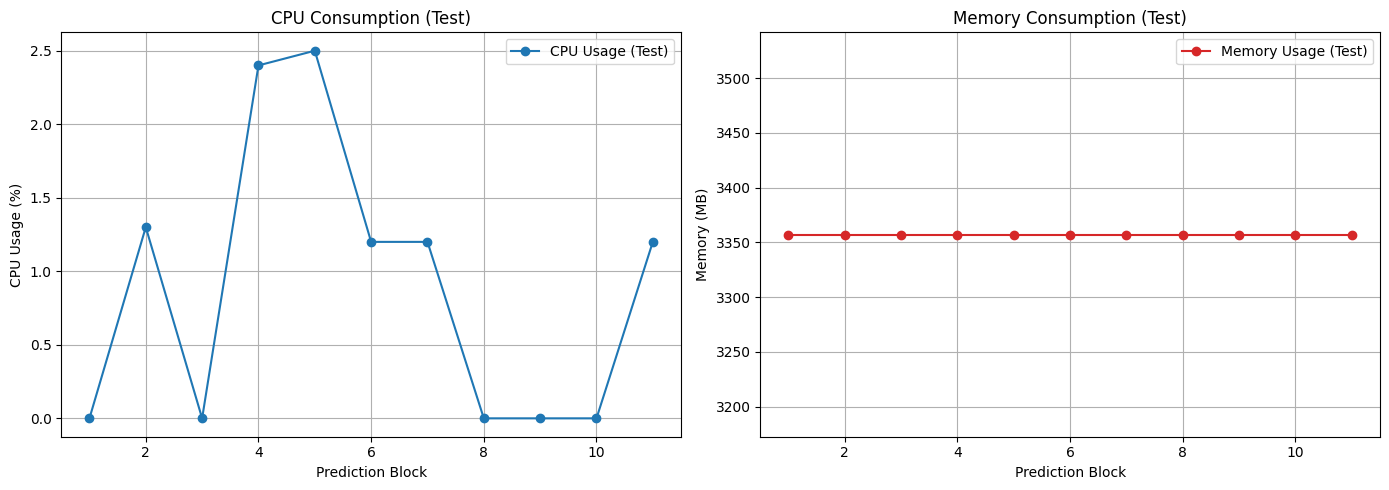

ROC FULL=1.0000
PR FULL=1.0000

====== Zero-Day: HTTPFlood ======
Total HTTPFlood in the original dataset: 140812
  Zero-days removed from training: 112649
  Zero-day in the original test: 28163
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 93.38s
CPU: 50.00%
Memory: 3263.61 MB
Energy: 9.34e+07 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.40 seconds
Average CPU usage (Test): 0.79%
Average memory usage (Test): 3263.64 MB
Estimated energy consumption: 9.50 Joules


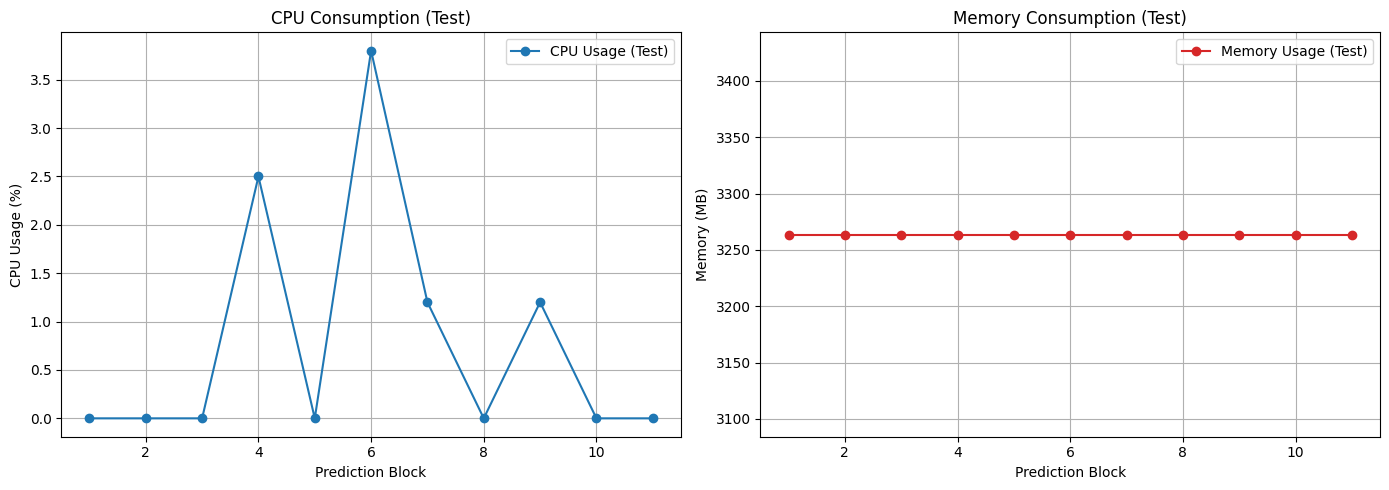


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.32 seconds
Average CPU usage (Test): 1.25%
Average memory usage (Test): 3263.64 MB
Estimated energy consumption: 20.43 Joules


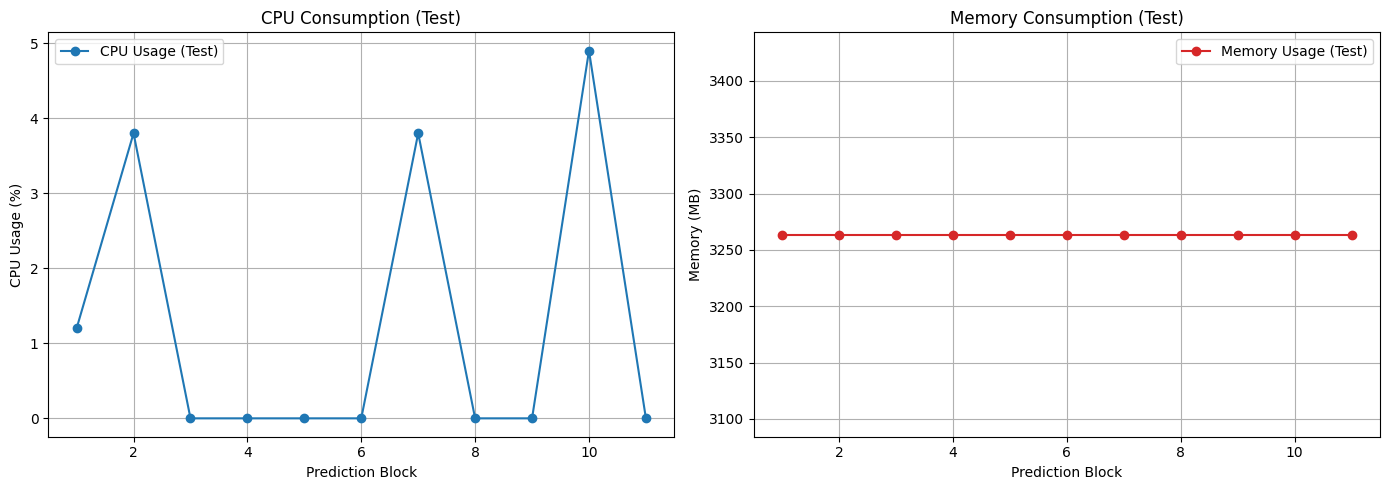

ROC FULL=1.0000
PR FULL=1.0000

====== Zero-Day: UDPScan ======
Total UDPScan in the original dataset: 15906
  Zero-days removed from training: 12713
  Zero-day in the original test: 3193
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 119.16s
CPU: 50.00%
Memory: 3280.01 MB
Energy: 1.19e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.46 seconds
Average CPU usage (Test): 2.68%
Average memory usage (Test): 3280.03 MB
Estimated energy consumption: 379.90 Joules


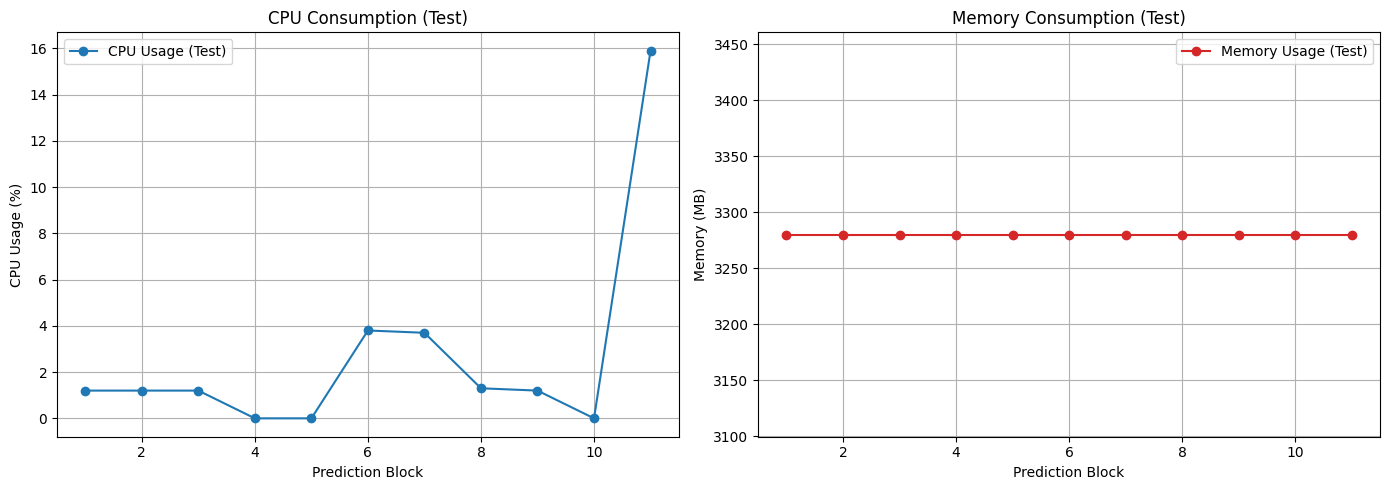


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.22 seconds
Average CPU usage (Test): 14.72%
Average memory usage (Test): 3280.04 MB
Estimated energy consumption: 31175.76 Joules


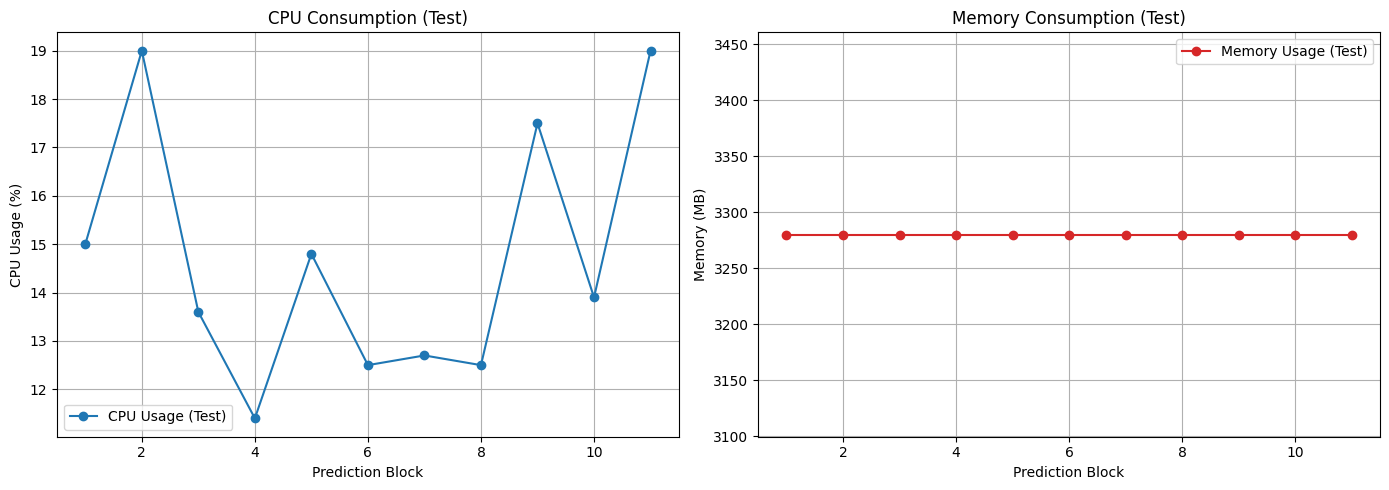

ROC FULL=1.0000
PR FULL=1.0000

====== Zero-Day: TCPConnectScan ======
Total TCPConnectScan in the original dataset: 20052
  Zero-days removed from training: 15999
  Zero-day in the original test: 4053
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 127.63s
CPU: 49.90%
Memory: 3354.23 MB
Energy: 1.27e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.41 seconds
Average CPU usage (Test): 0.56%
Average memory usage (Test): 3354.25 MB
Estimated energy consumption: 3.46 Joules


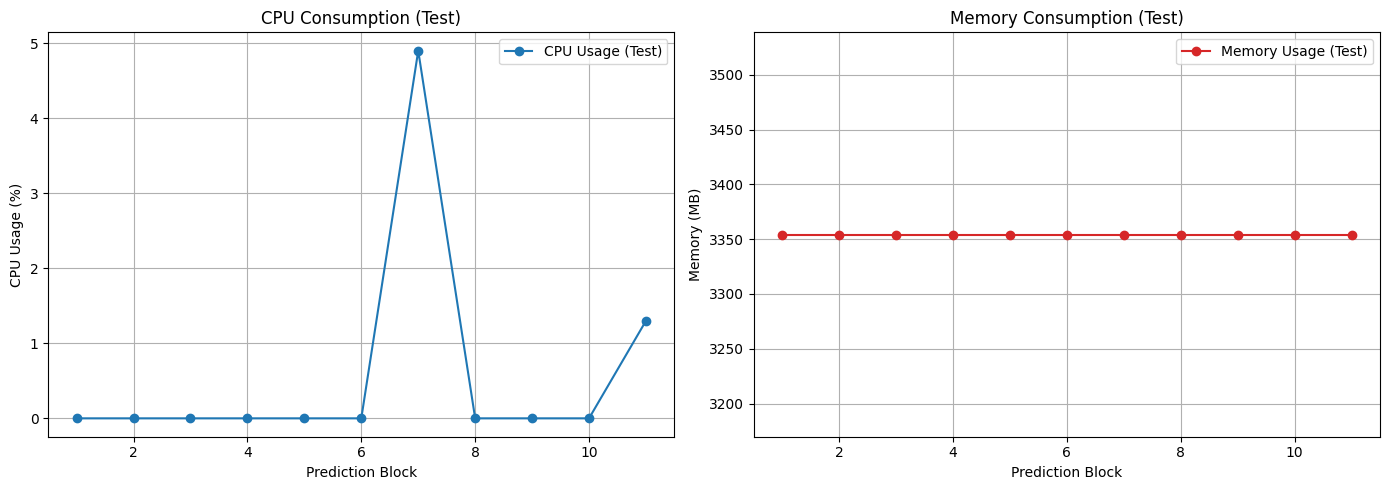


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.21 seconds
Average CPU usage (Test): 1.00%
Average memory usage (Test): 3354.26 MB
Estimated energy consumption: 9.70 Joules


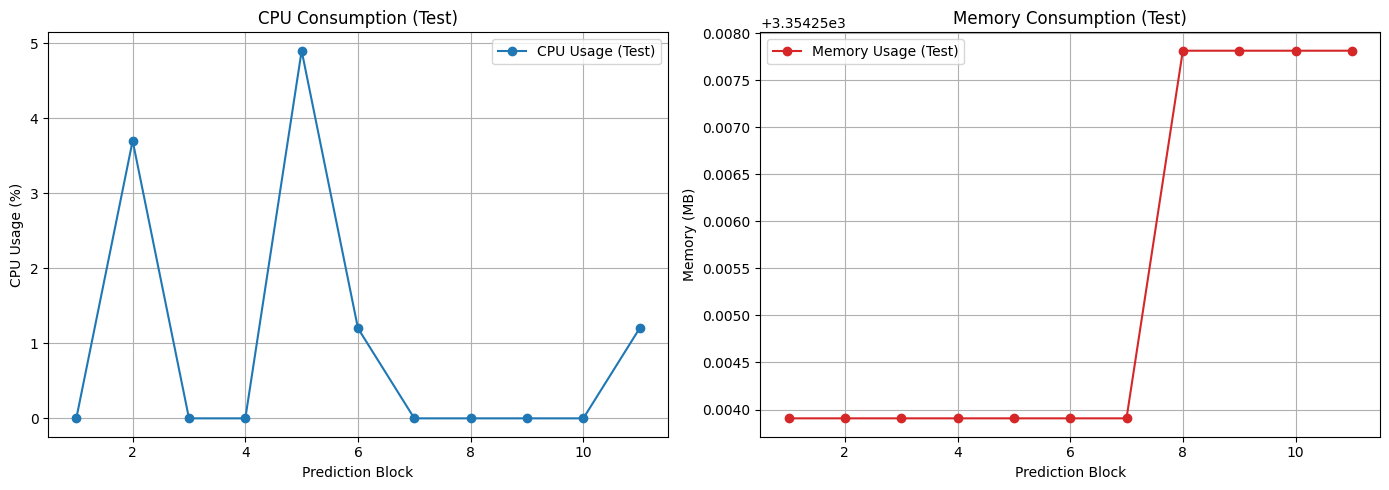

ROC FULL=1.0000
PR FULL=1.0000

====== Zero-Day: SlowrateDoS ======
Total SlowrateDoS in the original dataset: 73124
  Zero-days removed from training: 58621
  Zero-day in the original test: 14503
  Test full total: 243178

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 110.61s
CPU: 50.00%
Memory: 3222.54 MB
Energy: 1.11e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.46 seconds
Average CPU usage (Test): 0.68%
Average memory usage (Test): 3222.55 MB
Estimated energy consumption: 6.23 Joules


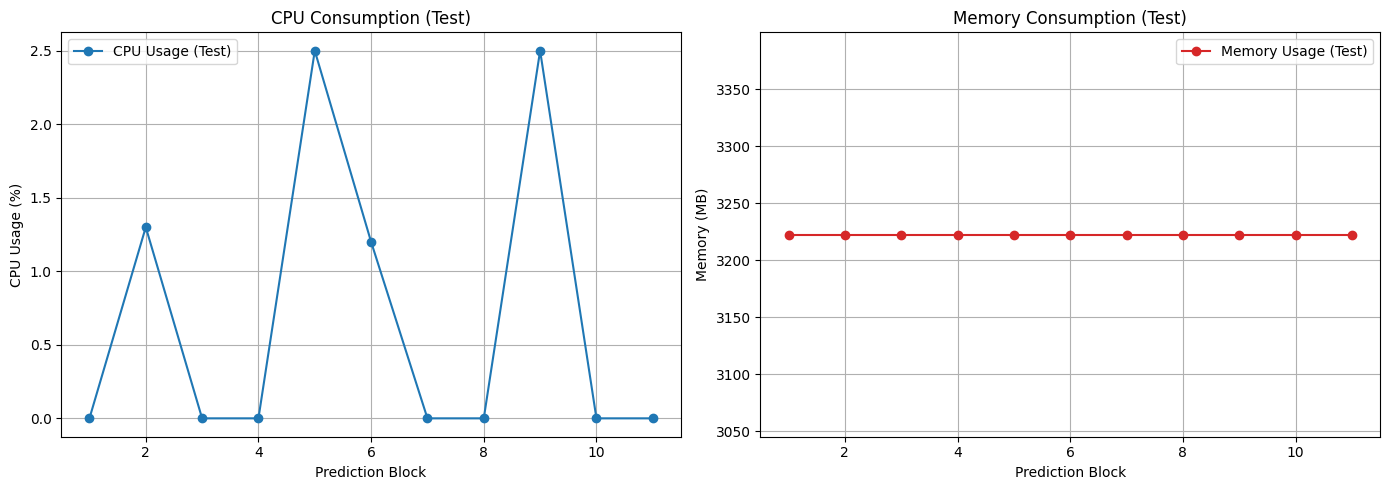


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.26 seconds
Average CPU usage (Test): 0.90%
Average memory usage (Test): 3222.55 MB
Estimated energy consumption: 7.36 Joules


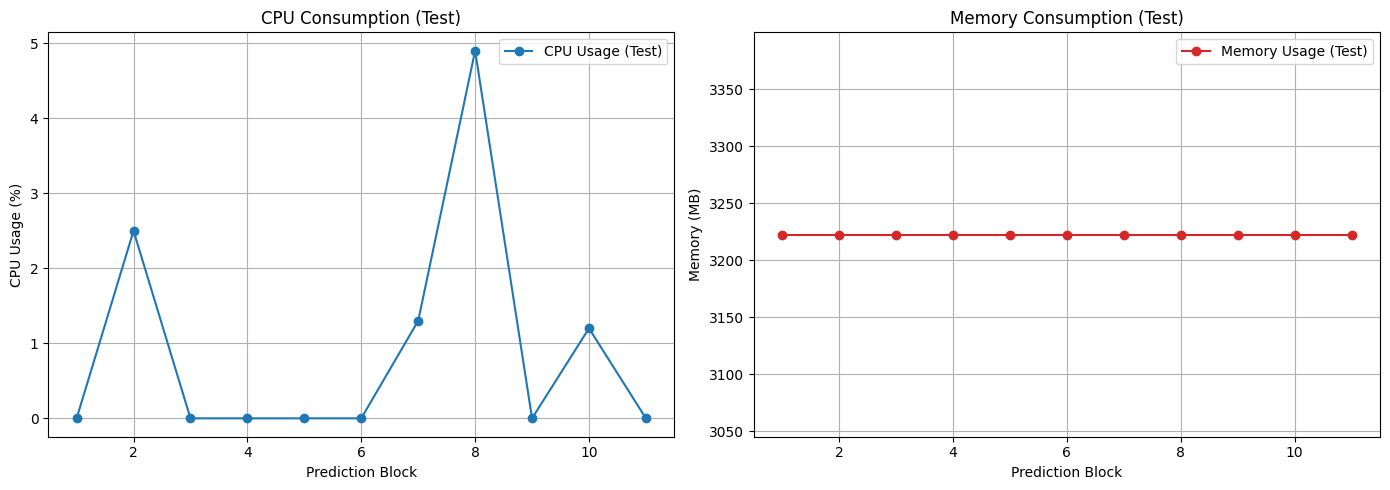

ROC FULL=1.0000
PR FULL=1.0000


In [ ]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import os


# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['Attack Type'] = encoded.loc[X_train.index, 'Attack Type']
X_test['Attack Type'] = encoded.loc[X_test.index, 'Attack Type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['ICMPFlood', 'UDPFlood', 'SYNFlood', 'SYNScan', 'HTTPFlood', 'UDPScan', 'TCPConnectScan', 'SlowrateDoS']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

model_name = "Random Forest"
roc_full_curves = []
pr_full_curves = []

# ===== LOOP PRINCIPAL =====
for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Contagem no dataset original ---
    total_in_original = (X['Attack Type'] == ataque_zero_day).sum()
    print(f"Total {ataque_zero_day} in the original dataset: {total_in_original}")
    mask_train = X_train['Attack Type'] != ataque_zero_day
    train_removed = (~mask_train).sum()

    X_train_clean = X_train.loc[mask_train].drop(columns=['Attack Type']).copy()
    y_train_clean = y_train.loc[mask_train].copy()
    print(f"  Zero-days removed from training: {train_removed}")

    mask_test_zero = X_test['Attack Type'] == ataque_zero_day
    X_test_zero_day = X_test.loc[mask_test_zero].drop(columns=['Attack Type']).copy()
    y_test_zero_day = y_test.loc[mask_test_zero].copy()
    print(f"  Zero-day in the original test: {mask_test_zero.sum()}")

    X_test_full = X_test.drop(columns=['Attack Type']).copy()
    y_test_full = y_test.copy()
    print(f"  Test full total: {len(X_test_full)}")

    # --- Balanceamento com SMOTE ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

    # --- Normalização ---
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # =============================
    # Codificação dos rótulos
    # =============================
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_balanced)
    y_test_full_encoded = le.transform(y_test_full)
    y_test_zero_day_encoded = le.transform(y_test_zero_day)

    # =============================
    # Treinamento do modelo
    # =============================
    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    recursos_rf = monitor_train_generic(model, X_train_scaled, y_train_encoded, "Random Forest")


    model.fit(X_train_scaled, y_train_encoded)

    # TESTE GERAL COM MONITORAMENTO
    # =============================
    print('\n====== General Resource Allocation ======')
    mstart_time = time.time()
    y_pred_full = model.predict(X_test_full_scaled)
    metrics_test_full = monitor_test_prediction(model, X_test_full_scaled)
    acc_teste_full = accuracy_score(y_test_full_encoded, y_pred_full)
    f1_teste_full = f1_score(y_test_full_encoded, y_pred_full, zero_division=1)
    precision_full = precision_score(y_test_full_encoded, y_pred_full, zero_division=1)
    recall_full = recall_score(y_test_full_encoded, y_pred_full, zero_division=1)


    # =============================
    # TESTE ZERO-DAY COM MONITORAMENTO
    # =============================
    print('\n====== Zero-Day Resource Allocation ======')
    start_time = time.time()
    y_pred_zero_day = model.predict(X_test_zero_day_scaled)
    metrics_zero_day = monitor_test_prediction(model, X_test_zero_day_scaled)
    acc_zero_day = accuracy_score(y_test_zero_day_encoded, y_pred_zero_day)
    f1_zero_day = f1_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)
    precision_zero = precision_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)
    recall_zero = recall_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)

    # =============================
    # Salvar resultados
    # =============================
    resultados_zero_day.append({
    'Ataque Zero-Day': ataque_zero_day,

    'Accuracy': acc_teste_full,
    'F1': f1_teste_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Time': metrics_test_full['total_time'],
    'CPU': metrics_test_full['avg_cpu'],
    'Memory': metrics_test_full['avg_mem'],
    'Energy': metrics_test_full['energia'],

    'ZD - Accuracy': acc_zero_day,
    'ZD - F1': f1_zero_day,
    'ZD - Precision': precision_zero,
    'ZD - Recall': recall_zero,
    'ZD - Time': metrics_zero_day['total_time'],
    'ZD - CPU': metrics_zero_day['avg_cpu'],
    'ZD - Memory': metrics_zero_day['avg_mem'],
    'ZD - Energy': metrics_zero_day['energia'],
})
    # =============================
    # CURVA ROC (gerada no mesmo loop)
    # =============================
    # TESTE FULL
    if hasattr(model, "predict_proba"):
        probs_full = model.predict_proba(X_test_full_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        probs_full = model.decision_function(X_test_full_scaled)
    else:
        raise AttributeError(f"O modelo {model.__class__.__name__} não possui predict_proba nem decision_function.")

    fpr_full, tpr_full, _ = roc_curve(y_test_full_encoded, probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    roc_full_curves.append((fpr_full, tpr_full, roc_auc_full, f"{ataque_zero_day}"))

    print(f"ROC FULL={roc_auc_full:.4f}")

    # =============================
    # PR CURVE (MODELOS NORMAIS) - TESTE FULL
    # =============================

    # Geração da PR-Curve
    precision_full, recall_full, _ = precision_recall_curve(y_test_full_encoded, probs_full)
    ap_full = average_precision_score(y_test_full_encoded, probs_full)

    # Armazena
    pr_full_curves.append((precision_full, recall_full, ap_full, ataque_zero_day))

    print(f"PR FULL={ap_full:.4f}")

    del model
    gc.collect()
    K.clear_session()

In [ ]:
attack_mapping = {
    'ICMPFlood': 'ICMP Flood',
    'UDPFlood': 'UDP Flood',
    'SYNFlood': 'SYN Flood',
    'SYNScan': 'SYN Scan',
    'HTTPFlood': 'HTTP Flood',
    'UDPScan': 'UDP Scan',
    'TCPConnectScan': 'TCP Connect Scan',
    'SlowrateDoS': 'Slow Rate DoS'
}

/tmp/ipython-input-1070250525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(roc_full_curves))


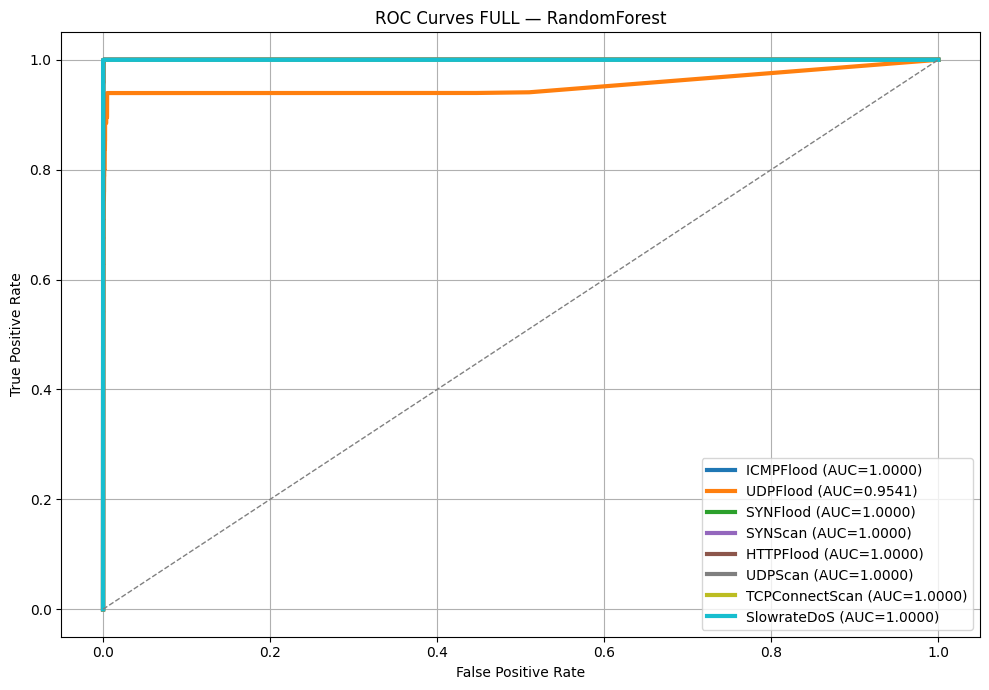

In [ ]:
# =========================================
# ROC CURVES (FULL)
# =========================================

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

plt.figure(figsize=(12, 8), dpi=300)

colors = plt.cm.get_cmap('tab20', len(roc_full_curves))

for i, (fpr, tpr, auc_val, label) in enumerate(roc_full_curves):

    pretty_label = attack_mapping.get(label, label)
    plt.plot(
        fpr,
        tpr,
        lw=2.8,
        color=colors(i),
        label=f"{pretty_label} (AUC={auc_val:.4f})"
    )

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curves Across All Attack Classes — {model_name}')
plt.grid(alpha=0.3)

plt.legend(loc='lower right', ncol=2, frameon=True)

plt.tight_layout()

os.makedirs("roc_curves", exist_ok=True)
plt.savefig(f"roc_curves/{model_name}_ALL_FULL_ROC.png", dpi=400, bbox_inches='tight')
plt.show()

/tmp/ipython-input-3942214508.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(pr_full_curves))


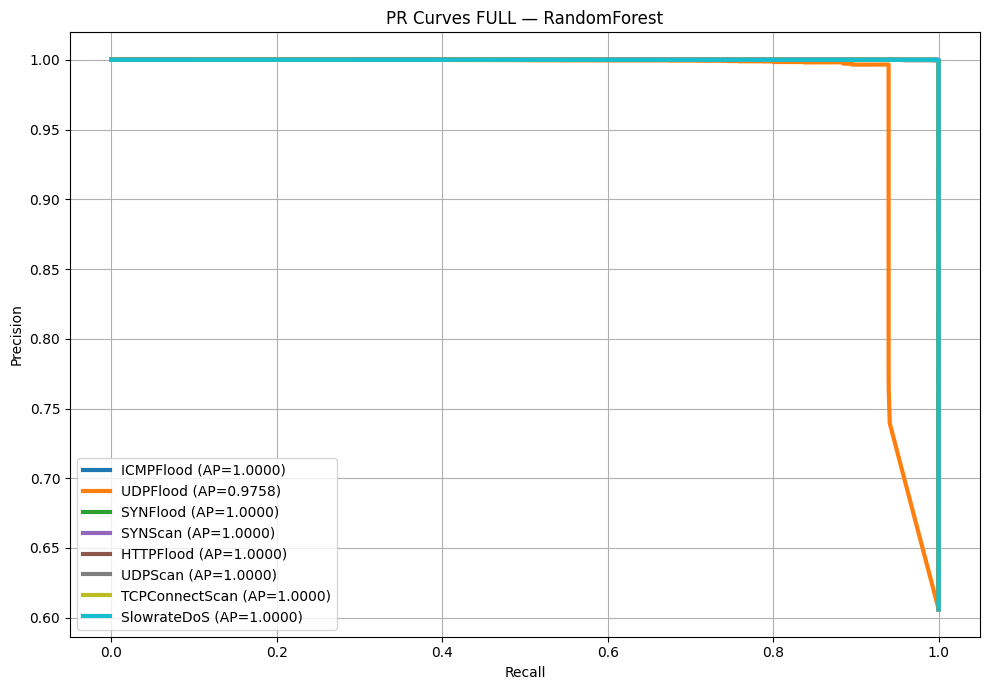

In [ ]:
# =========================================
# PR CURVES (FULL)
# =========================================

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

plt.figure(figsize=(12, 8), dpi=300)

colors = plt.cm.get_cmap('tab20', len(pr_full_curves))

for i, (precision, recall, ap_val, label) in enumerate(pr_full_curves):
    pretty_label = attack_mapping.get(label, label)
    plt.plot(
        recall,
        precision,
        lw=2.8,
        color=colors(i),
        label=f"{pretty_label} (AUC={auc_val:.4f})"
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curves Across All Attack Classes — {model_name}')
plt.grid(alpha=0.3)

plt.legend(loc='lower left', ncol=2, frameon=True)

plt.tight_layout()

os.makedirs("pr_curves", exist_ok=True)
plt.savefig(f"pr_curves/{model_name}_ALL_FULL_PR.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
!pip install tabulate

In [ ]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤═════════╤═══════════╤══════════╤═════════════╤═════════════════╤════════════╤══════════════════╤═══════════════╤═════════════╤════════════╤═══════════════╤═══════════════╕
│ Ataque Zero-Day   │   Accuracy │       F1 │   Precision │   Recall │    Time │       CPU │   Memory │      Energy │   ZD - Accuracy │    ZD - F1 │   ZD - Precision │   ZD - Recall │   ZD - Time │   ZD - CPU │   ZD - Memory │   ZD - Energy │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪═════════╪═══════════╪══════════╪═════════════╪═════════════════╪════════════╪══════════════════╪═══════════════╪═════════════╪════════════╪═══════════════╪═══════════════╡
│ ICMPFlood         │   0.999761 │ 0.999803 │    0.99998  │ 0.999627 │ 2.47412 │  0.663636 │  3130.95 │     5.78498 │      1          │ 1          │                1 │    1          │     1.18569 │   1        │       3133.77 │       9.4855  │
├───────────────────┼───────

In [ ]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')